In [2]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

## Igor's speedy method...

In [3]:
from __future__ import print_function, absolute_import
from IPython import display
import math
import matplotlib.pyplot as plt
import numpy as np

from multiple_traj_opt import (
    make_mto,
    MultipleTrajOpt,
    initial_conditions_Russ,
    initial_conditions_grid,
    initial_conditions_random,
)
from nn_system.networks import *

from igor import (
    igor_traj_opt_serial,
    igor_traj_opt_parallel,
    igor_supervised_learning,
    igor_supervised_learning_cuda,
    visualize_intermediate_results,
)

## Applying to to Pendulum

In [185]:
total_iterations = 1
num_trajectories = 50**2
# ic_list = initial_conditions_grid(num_trajectories, (0., 2*math.pi), (-5., 5.))
ic_list = initial_conditions_random(num_trajectories, (0., 2*math.pi), (-5., 5.))

In [186]:
from traj.vi_utils import do_dircol_pendulum
trajectories, dircols = igor_traj_opt(do_dircol_pendulum, ic_list, net, num_samples=32, min_timestep=0.1, max_timestep=0.5) 

completed 10 trajectories
completed 20 trajectories
completed 30 trajectories
completed 40 trajectories
completed 50 trajectories
completed 60 trajectories
completed 70 trajectories
completed 80 trajectories
completed 90 trajectories
completed 100 trajectories
completed 110 trajectories
completed 120 trajectories
completed 130 trajectories
completed 140 trajectories
completed 150 trajectories
completed 160 trajectories
completed 170 trajectories
completed 180 trajectories
completed 190 trajectories
result=SolutionResult.kIterationLimit
completed 200 trajectories
completed 210 trajectories
completed 220 trajectories
completed 230 trajectories
completed 240 trajectories
completed 250 trajectories
completed 260 trajectories
completed 270 trajectories
completed 280 trajectories
result=SolutionResult.kIterationLimit
completed 290 trajectories
completed 300 trajectories
completed 310 trajectories
completed 320 trajectories
completed 330 trajectories
completed 340 trajectories
completed 350 t

In [205]:
# net = FCBIG(2, 32)
kNetConstructor = lambda: MLP(2, 32, layer_norm=False)
net = kNetConstructor()
igor_supervised_learning(trajectories, net, use_prox=False, iter_repeat=100, EPOCHS=20, lr=2e-2)

(80000, 2)
(80000, 1)
[1,   100] loss: 0.001
[2,   100] loss: 0.001
[3,   100] loss: 0.000
[4,   100] loss: 0.000
[5,   100] loss: 0.000
[6,   100] loss: 0.000
[7,   100] loss: 0.000
[8,   100] loss: 0.000
[9,   100] loss: 0.000
[10,   100] loss: 0.000
[11,   100] loss: 0.000
[12,   100] loss: 0.000
[13,   100] loss: 0.000
[14,   100] loss: 0.000
[15,   100] loss: 0.000
[16,   100] loss: 0.000
[17,   100] loss: 0.000
[18,   100] loss: 0.000
[19,   100] loss: 0.000
[20,   100] loss: 0.000
Finished Training


In [ ]:
# PATH = 'numpy_saves/good_igor_nn_pend_MLP_2_32_no_layer_norm.pt'
# torch.save(net.state_dict(), PATH)

truncating


<IPython.core.display.Javascript object>


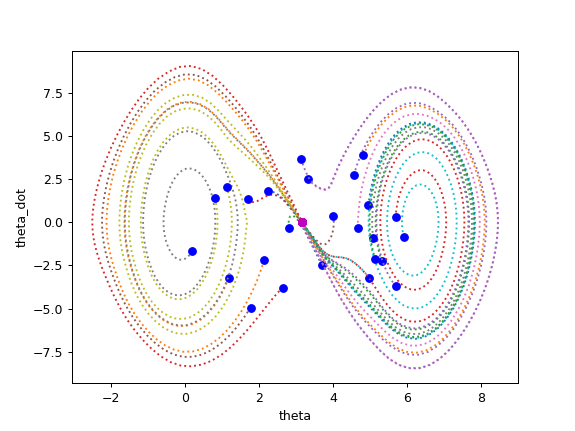

In [189]:
# visualize_intermediate_results(trajectories, 961, 32, network=net, ic_list=ic_list, ic_scale=1., constructor=kNetConstructor, WALLCLOCK_TIME_LIMIT=15)
visualize_intermediate_results([], 2500, 32, network=net, ic_list=ic_list, ic_scale=1., constructor=kNetConstructor, WALLCLOCK_TIME_LIMIT=15)

## Applying to to Cartpole

In [5]:
num_trajectories = 100**2
# ic_gen = lambda: initial_conditions_grid(num_trajectories, (0., 2*math.pi), (-5., 5.))
# ic_gen = lambda: initial_conditions_random(num_trajectories, (0., 2*math.pi), (-5., 5.))
# ic_list = np.hstack((ic_gen(), ic_gen()))
# print('ic_list.shape: ', ic_list.shape)
# state_limits = (-5./2, 5./2)

from multiple_traj_opt import (initial_conditions_random_all_dims)
x_lim     = (-1., 1.)
t_lim     = (0., 2*math.pi)
x_dot_lim = (-1., 1.)
t_dot_lim = (-1., 1.) #(-5./2, 5./2)
ic_list = initial_conditions_random_all_dims(num_trajectories, (x_lim, t_lim, x_dot_lim, t_dot_lim) )
# for i, ic in enumerate(ic_list):
#     print("{} ({: .2f} {: .2f} {: .2f} {: .2f})".format(i, *ic))

ic_list = initial_conditions_random_all_dims(num_trajectories, ((-1., 1.), (0., 2*math.pi), (-1., 1.), (-1., 1.)) )

In [ ]:
# %matplotlib inline
from traj.vi_utils import do_dircol_cartpole
# trajectories, dircols, results = igor_traj_opt_serial(do_dircol_cartpole, ic_list, torque_limit=180., should_vis=False)#, num_samples=16, min_timestep=0.1, max_timestep=0.5) 
trajectories, dircols, results = igor_traj_opt_parallel(do_dircol_cartpole, ic_list, torque_limit=250., should_vis=False, num_samples=21, min_timestep=0.1, max_timestep=0.4) 



result=SolutionResult.kInfeasibleConstraints
2148 took 5.63708019257
358 took 5.9012029171
result=SolutionResult.kInfeasibleConstraints
0 took 6.29693579674
1432 took 6.49738407135
1790 took 7.47765207291
1074 took 7.93424487114
716 took 9.16350293159
1 took 3.2506840229
result=SolutionResult.kInfeasibleConstraints
359 took 5.22719192505
1433 took 5.53879094124
result=SolutionResult.kInfeasibleConstraints
1075 took 5.73278880119
result=SolutionResult.kInfeasibleConstraints
717 took 4.7019610405
2149 took 8.30647993088
1791 took 6.87489199638
2 took 5.57202887535
result=SolutionResult.kInfeasibleConstraints
1434 took 5.38425111771
result=SolutionResult.kInfeasibleConstraints
718 took 5.12987685204
360 took 8.37358403206
result=SolutionResult.kInfeasibleConstraints
3 took 5.59469985962
1435 took 3.31557798386
2150 took 8.54812002182
result=SolutionResult.kInfeasibleConstraints
719 took 4.05342292786
result=SolutionResult.kInfeasibleConstraints
361 took 4.66617321968
1076 took 11.52893590

result=SolutionResult.kUnknownError
387 took 20.2018821239
739 took 9.4805059433
29 took 9.47863101959
result=SolutionResult.kUnknownError
1813 took 20.2765240669
result=SolutionResult.kUnknownError
1460 took 20.1654908657
740 took 5.38750886917
result=SolutionResult.kUnknownError
1096 took 20.1653659344
result=SolutionResult.kUnknownError
2178 took 20.2129619122
result=SolutionResult.kInfeasibleConstraints
741 took 4.14932394028
1461 took 8.45431995392
result=SolutionResult.kInfeasibleConstraints
2179 took 3.92658019066
1097 took 9.80039596558
result=SolutionResult.kInfeasibleConstraints
2180 took 5.62831282616
result=SolutionResult.kUnknownError
388 took 20.2668058872
30 took 19.6694869995
result=SolutionResult.kUnknownError
1814 took 20.2272369862
1098 took 7.33640193939
742 took 18.6825480461
2181 took 10.4828350544
result=SolutionResult.kUnknownError
1462 took 20.1222360134
389 took 13.6136860847
1099 took 11.1399421692
result=SolutionResult.kInfeasibleConstraints
2182 took 6.5216

2197 took 20.1737987995
56 took 3.26524591446
result=SolutionResult.kUnknownError
1126 took 20.2167038918
result=SolutionResult.kInfeasibleConstraints
57 took 3.3909509182
result=SolutionResult.kUnknownError
1838 took 20.3144500256
1127 took 4.20506215096
768 took 15.5024349689
58 took 2.19683504105
result=SolutionResult.kUnknownError
1484 took 20.1704418659
2198 took 9.23666405678
result=SolutionResult.kUnknownError
411 took 20.2918989658
result=SolutionResult.kInfeasibleConstraints
769 took 4.30768013
result=SolutionResult.kInfeasibleConstraints
1839 took 5.10807013512
result=SolutionResult.kInfeasibleConstraints
59 took 4.74606108665
result=SolutionResult.kInfeasibleConstraints
1128 took 7.16932606697
412 took 6.98292684555
result=SolutionResult.kInfeasibleConstraints
60 took 5.11512899399
2199 took 9.4811770916
result=SolutionResult.kInfeasibleConstraints
1840 took 6.56974101067
1129 took 7.10795092583
result=SolutionResult.kInfeasibleConstraints
61 took 4.77778911591
result=Soluti

1511 took 4.82428812981
result=SolutionResult.kInfeasibleConstraints
790 took 5.43064808846
82 took 9.90295910835
791 took 3.99406409264
result=SolutionResult.kUnknownError
432 took 20.2435770035
result=SolutionResult.kUnknownError
2229 took 20.1329770088
83 took 6.7174038887
1153 took 15.7125608921
1512 took 9.04990816116
result=SolutionResult.kInfeasibleConstraints
433 took 4.14881396294
792 took 5.83156514168
result=SolutionResult.kInfeasibleConstraints
434 took 3.86237287521
1513 took 5.20091509819
result=SolutionResult.kInfeasibleConstraints
793 took 5.98274207115
result=SolutionResult.kUnknownError
1859 took 20.1859269142
result=SolutionResult.kInfeasibleConstraints
1514 took 4.59211397171
1154 took 11.4055008888
result=SolutionResult.kInfeasibleConstraints
1515 took 5.32626390457
result=SolutionResult.kUnknownError
2230 took 20.2505068779
result=SolutionResult.kUnknownError
84 took 20.2098379135
result=SolutionResult.kInfeasibleConstraints
1516 took 5.4918320179
result=SolutionR

812 took 6.55530619621
107 took 6.51919794083
1884 took 6.10600399971
result=SolutionResult.kInfeasibleConstraints
813 took 6.41320991516
result=SolutionResult.kUnknownError
1535 took 20.3037490845
814 took 5.16255998611
463 took 14.0551681519
result=SolutionResult.kUnknownError
2254 took 20.0882089138
1885 took 7.72701716423
1536 took 8.46431684494
result=SolutionResult.kInfeasibleConstraints
2255 took 4.96579313278
result=SolutionResult.kUnknownError
1176 took 20.1320168972
815 took 9.26587605476
result=SolutionResult.kUnknownError
108 took 20.1811511517
result=SolutionResult.kInfeasibleConstraints
1537 took 8.14476299286
464 took 14.3134629726
465 took 2.07430100441
result=SolutionResult.kUnknownError
1886 took 20.2741680145
109 took 9.25743699074
result=SolutionResult.kUnknownError
2256 took 20.1860659122
result=SolutionResult.kInfeasibleConstraints
1887 took 5.40804791451
result=SolutionResult.kUnknownError
1177 took 20.1650240421
result=SolutionResult.kUnknownError
816 took 20.30

result=SolutionResult.kUnknownError
128 took 20.2866899967
839 took 4.64388489723
result=SolutionResult.kInfeasibleConstraints
2282 took 5.78902387619
result=SolutionResult.kInfeasibleConstraints
486 took 5.70527291298
1563 took 10.4946520329
840 took 4.55025815964
result=SolutionResult.kInfeasibleConstraints
2283 took 3.89677405357
result=SolutionResult.kInfeasibleConstraints
487 took 5.5274040699
result=SolutionResult.kInfeasibleConstraints
2284 took 2.98704195023
841 took 3.77718687057
result=SolutionResult.kUnknownError
1198 took 20.1374280453
result=SolutionResult.kUnknownError
1910 took 20.3438270092
1564 took 9.49788308144
result=SolutionResult.kInfeasibleConstraints
488 took 7.07052898407
result=SolutionResult.kInfeasibleConstraints
1199 took 5.06491589546
1911 took 3.44953012466
result=SolutionResult.kUnknownError
129 took 20.1693718433
842 took 10.2222950459
result=SolutionResult.kInfeasibleConstraints
489 took 5.61219501495
1912 took 4.71489810944
1200 took 6.28766989708
156

result=SolutionResult.kUnknownError
1583 took 20.1306169033
result=SolutionResult.kUnknownError
153 took 20.2521390915
154 took 4.07202315331
result=SolutionResult.kInfeasibleConstraints
2312 took 5.9121761322
result=SolutionResult.kInfeasibleConstraints
872 took 6.23615288734
result=SolutionResult.kUnknownError
510 took 20.3091950417
1223 took 7.86004185677
1584 took 9.32157492638
result=SolutionResult.kInfeasibleConstraints
511 took 5.79334902763
155 took 9.44784283638
result=SolutionResult.kInfeasibleConstraints
1224 took 6.10696601868
result=SolutionResult.kInfeasibleConstraints
1585 took 5.71074509621
result=SolutionResult.kUnknownError
1931 took 20.1272010803
result=SolutionResult.kInfeasibleConstraints
156 took 6.17177700996
result=SolutionResult.kInfeasibleConstraints
1586 took 4.73266816139
512 took 11.4016969204
result=SolutionResult.kUnknownError
2313 took 20.2004520893
result=SolutionResult.kUnknownError
873 took 20.1712701321
result=SolutionResult.kInfeasibleConstraints
15

1250 took 4.61791706085
1609 took 17.6372480392
result=SolutionResult.kUnknownError
902 took 20.2419970036
1957 took 14.9898920059
1610 took 2.03289413452
1251 took 5.36096191406
result=SolutionResult.kInfeasibleConstraints
1958 took 5.57716012001
result=SolutionResult.kInfeasibleConstraints
1611 took 5.14213585854
result=SolutionResult.kInfeasibleConstraints
1252 took 3.04834985733
177 took 11.8570270538
903 took 9.86884903908
result=SolutionResult.kUnknownError
2334 took 20.2267160416
result=SolutionResult.kInfeasibleConstraints
1959 took 4.6131939888
result=SolutionResult.kUnknownError
535 took 20.2589251995
178 took 9.52086091042
1253 took 10.6560988426
179 took 2.30986404419
2335 took 9.00046610832
904 took 10.7597470284
result=SolutionResult.kInfeasibleConstraints
536 took 5.65498614311
1612 took 16.0145261288
1254 took 6.64416503906
1960 took 14.4158949852
2336 took 7.04874300957
2337 took 3.00840616226
1613 took 9.02316212654
result=SolutionResult.kUnknownError
180 took 20.1899

924 took 20.1666419506
result=SolutionResult.kInfeasibleConstraints
560 took 5.83277392387
result=SolutionResult.kInfeasibleConstraints
1280 took 5.74214315414
198 took 10.3075449467
result=SolutionResult.kInfeasibleConstraints
199 took 2.89447903633
2359 took 15.385117054
result=SolutionResult.kInfeasibleConstraints
200 took 2.51266098022
1281 took 7.21107506752
result=SolutionResult.kUnknownError
1985 took 20.2304000854
result=SolutionResult.kUnknownError
1636 took 20.2861270905
result=SolutionResult.kInfeasibleConstraints
1282 took 5.20020914078
result=SolutionResult.kUnknownError
925 took 20.2210879326
result=SolutionResult.kInfeasibleConstraints
1283 took 5.2799577713
result=SolutionResult.kUnknownError
561 took 20.0908629894
562 took 2.68478703499
563 took 2.0409719944
result=SolutionResult.kUnknownError
2360 took 20.2108700275
1284 took 7.58002781868
result=SolutionResult.kUnknownError
201 took 20.2406878471
result=SolutionResult.kUnknownError
1986 took 20.320472002
1285 took 2.

1665 took 20.1443991661
result=SolutionResult.kInfeasibleConstraints
1666 took 2.55053210258
1314 took 12.4964029789
2011 took 3.18689894676
2012 took 3.8264169693
946 took 12.7285480499
1667 took 6.01363515854
223 took 11.7119369507
result=SolutionResult.kUnknownError
2378 took 20.2187387943
1315 took 8.31767892838
2013 took 4.84064793587
result=SolutionResult.kUnknownError
588 took 20.2548630238
947 took 5.72784590721
result=SolutionResult.kInfeasibleConstraints
1316 took 2.87144613266
1668 took 9.22911477089
2379 took 7.73124313354
2014 took 15.5226249695
948 took 14.5962569714
589 took 16.6157341003
result=SolutionResult.kUnknownError
224 took 20.1193630695
result=SolutionResult.kInfeasibleConstraints
225 took 2.47198200226
result=SolutionResult.kUnknownError
1317 took 20.1713018417
result=SolutionResult.kInfeasibleConstraints
590 took 5.99559807777
949 took 8.06318497658
result=SolutionResult.kInfeasibleConstraints
226 took 3.37174987793
2380 took 19.0513401031
result=SolutionResu

result=SolutionResult.kInfeasibleConstraints
973 took 3.71712303162
result=SolutionResult.kUnknownError
1338 took 20.2814588547
result=SolutionResult.kUnknownError
2037 took 20.2424719334
result=SolutionResult.kInfeasibleConstraints
1695 took 5.04056882858
result=SolutionResult.kInfeasibleConstraints
974 took 5.17104911804
result=SolutionResult.kUnknownError
251 took 20.3600459099
result=SolutionResult.kInfeasibleConstraints
1339 took 6.32170915604
2404 took 16.6281690598
result=SolutionResult.kInfeasibleConstraints
1696 took 3.8944580555
2038 took 12.2718429565
result=SolutionResult.kUnknownError
614 took 20.1647570133
2039 took 6.90421390533
result=SolutionResult.kUnknownError
975 took 20.2153689861
result=SolutionResult.kUnknownError
252 took 20.1799869537
result=SolutionResult.kInfeasibleConstraints
615 took 9.33485388756
result=SolutionResult.kUnknownError
1340 took 20.2390499115
result=SolutionResult.kUnknownError
1697 took 20.2781419754
result=SolutionResult.kUnknownError
2405 t

In [ ]:
import pickle
# f = open('test.pkl', 'wb')
# pickle.dump((trajectories, dircols, results), f)
# f.close()
# f = open('test.pkl', 'rb')
# obj = pickle.load(f)
# f.close()

In [1]:
# obj

NameError: name 'obj' is not defined

In [11]:
# net = FCBIG(4, 32)
kNetConstructor = lambda: MLP(4, 128, layer_norm=False)
net = kNetConstructor()
# test_traj = list((elem[:] for elem in trajectories[0]))
# igor_supervised_learning([test_traj], net, use_prox=False, iter_repeat=1000, EPOCHS=20, lr=1e-3)

import time
start = time.time()
# igor_supervised_learning(trajectories, net, use_prox=False, iter_repeat=1000, EPOCHS=10, lr=1e-2)
# igor_supervised_learning_cuda(trajectories, net, use_prox=False, iter_repeat=2000, EPOCHS=50, lr=5e-3)
igor_supervised_learning_cuda(trajectories, net, use_prox=False, iter_repeat=10, EPOCHS=50, lr=1e-3)
print("took {}".format(time.time() - start))



(200000, 4)
(200000, 1)
[1,    10] loss: 83.435
[2,    10] loss: 83.009
[3,    10] loss: 82.636
[4,    10] loss: 82.246
[5,    10] loss: 81.823
[6,    10] loss: 81.371
[7,    10] loss: 80.897
[8,    10] loss: 80.403
[9,    10] loss: 79.892
[10,    10] loss: 79.366
[11,    10] loss: 78.822
[12,    10] loss: 78.249
[13,    10] loss: 77.631
[14,    10] loss: 76.955
[15,    10] loss: 76.243
[16,    10] loss: 75.543
[17,    10] loss: 74.871
[18,    10] loss: 74.227
[19,    10] loss: 73.603
[20,    10] loss: 73.001
[21,    10] loss: 72.413
[22,    10] loss: 71.832
[23,    10] loss: 71.257
[24,    10] loss: 70.677
[25,    10] loss: 70.083
[26,    10] loss: 69.468
[27,    10] loss: 68.840
[28,    10] loss: 68.208
[29,    10] loss: 67.572
[30,    10] loss: 66.923
[31,    10] loss: 66.260
[32,    10] loss: 65.591
[33,    10] loss: 64.933
[34,    10] loss: 64.285
[35,    10] loss: 63.642
[36,    10] loss: 63.005
[37,    10] loss: 62.373
[38,    10] loss: 61.746
[39,    10] loss: 61.125
[40,    10

In [24]:
igor_supervised_learning_cuda(trajectories, net, use_prox=False, iter_repeat=10, EPOCHS=50, lr=4e-3)

(200000, 4)
(200000, 1)
[1,    10] loss: 28.442
[2,    10] loss: 23.746
[3,    10] loss: 22.665
[4,    10] loss: 22.106
[5,    10] loss: 21.796
[6,    10] loss: 21.715
[7,    10] loss: 21.657
[8,    10] loss: 21.621
[9,    10] loss: 21.602
[10,    10] loss: 21.592
[11,    10] loss: 21.583
[12,    10] loss: 21.576
[13,    10] loss: 21.571
[14,    10] loss: 21.566
[15,    10] loss: 21.562
[16,    10] loss: 21.558
[17,    10] loss: 21.555
[18,    10] loss: 21.551
[19,    10] loss: 21.548
[20,    10] loss: 21.545
[21,    10] loss: 21.541
[22,    10] loss: 21.538
[23,    10] loss: 21.535
[24,    10] loss: 21.532
[25,    10] loss: 21.528
[26,    10] loss: 21.525
[27,    10] loss: 21.522
[28,    10] loss: 21.518
[29,    10] loss: 21.515
[30,    10] loss: 21.511
[31,    10] loss: 21.508
[32,    10] loss: 21.504
[33,    10] loss: 21.501
[34,    10] loss: 21.497
[35,    10] loss: 21.493
[36,    10] loss: 21.490
[37,    10] loss: 21.486
[38,    10] loss: 21.482
[39,    10] loss: 21.478
[40,    10

diffs.shape: (710,)
idcs: [318 598 558 177 497] 
 values: [ 29.04534206  78.32405629  78.32408644 262.01432965  78.32406857]
tensor([[ 130.7213],
        [ 180.0000],
        [ 180.0000],
        [-160.3384],
        [ 180.0000]]) tensor([[ 0.5601, -0.0826, -1.3197, -2.5981],
        [-3.1237, -1.1459, -2.7750, -3.0416],
        [-1.5069, -0.2307, -1.4514, -2.5032],
        [ 0.0963,  0.4458, -2.1767, -2.3357],
        [ 0.6316, -0.4563, -2.4041, -1.9267]]) [[101.67598365]
 [101.67594371]
 [101.67591356]
 [101.67597949]
 [101.67593143]]


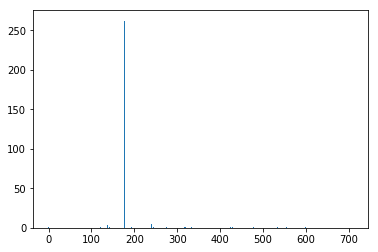

In [57]:
# Let’s check which paths are causing a problem for us and see if removing them might help.
all_inputs = np.vstack([np.expand_dims(traj[1], axis=0) for traj in trajectories])
all_labels = np.vstack([np.expand_dims(traj[2], axis=0) for traj in trajectories])
all_inputs = all_inputs.reshape(-1, all_inputs.shape[-1])
all_labels = all_labels.reshape(-1, all_labels.shape[-1])
safe_idcs = []
for i in range(all_labels.shape[0]):
    inp, label = all_inputs[i], all_labels[i]
    if not np.allclose(inp, (0.0000e+00,  3.1416e+00,  0.0000e+00,  0.0000e+00), atol=1e-2):
        safe_idcs.append(i)
# print("safe_idcs: ", safe_idcs)
all_inputs = all_inputs[safe_idcs]
all_labels = all_labels[safe_idcs]

inputs = torch.tensor(all_inputs)
labels = torch.tensor(all_labels)
net.cpu()
outputs = net(inputs)
diffs = np.abs((labels - outputs).clone().detach().numpy()).reshape((1, -1))[0]
print("diffs.shape: {}".format(diffs.shape))
K = 5
plt.bar(np.arange(len(diffs)), diffs, align='center') # <- Comment this out?
idcs = np.argpartition(diffs, -K)[-K:]
values = diffs[idcs]
print("idcs: {} \n values: {}".format(idcs, values))
print(labels[idcs], inputs[idcs], outputs.clone().detach().numpy()[idcs])

truncating


<IPython.core.display.Javascript object>


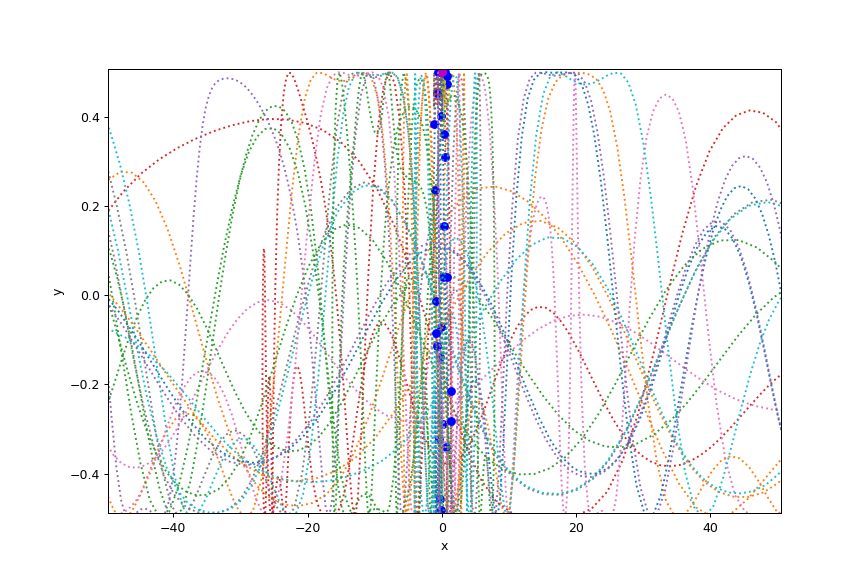

4
last x_knot:  [ 6.04324462e-05  3.14159265e+00 -5.19178189e-09 -6.29363787e-10]
4
last x_knot:  [1485.3804351    20.40688916  337.09244074    2.63383786]
4
last x_knot:  [ 1.52696124e+03  1.37191580e+01  3.24642781e+02 -3.61011737e-01]
4
last x_knot:  [-224.75232171  -14.08230848 -130.93822049    5.05151246]
4
last x_knot:  [6.04225383e-05 3.14159265e+00 5.41323837e-09 6.56200626e-10]
4
last x_knot:  [ 6.04321552e-05  3.14159265e+00 -4.88037393e-09 -5.91616756e-10]
4
last x_knot:  [1.82877201e+03 7.22619242e+00 1.94023627e+02 1.11910458e-01]
4
last x_knot:  [ 1.74069257e+03  1.38562924e+01  3.40918755e+02 -7.58995398e-02]
4
last x_knot:  [ 6.04309098e-05  3.14159265e+00 -3.54730681e-09 -4.29998758e-10]
4
last x_knot:  [ 1.77974093e+03  1.37967693e+01  3.43473307e+02 -7.30956884e-01]
4
last x_knot:  [ 6.04396062e-05  3.14159266e+00 -1.28556117e-08 -1.55838639e-09]
4
last x_knot:  [-1.41338508e+03 -1.39568289e+01 -3.37046441e+02 -1.06925504e+00]
4
last x_knot:  [6.04253637e-05 3.141592

In [29]:
from igor import (
#     igor_traj_opt,
#     igor_supervised_learning,
    visualize_intermediate_results,
)
# visualize_intermediate_results(trajectories, num_trajectories, 32, network=net, ic_list=ic_list, ic_scale=1., constructor=kNetConstructor, WALLCLOCK_TIME_LIMIT=15)
# vis_trajectories = trajectories
vis_trajectories = []
visualize_intermediate_results(vis_trajectories, num_trajectories, 32, network=net.cpu(), 
                               ic_list=ic_list, ic_scale=1., 
                               constructor=kNetConstructor, WALLCLOCK_TIME_LIMIT=60,
                               expmt="cartpole", plot_type="tip_scatter")

## Applying to to Acrobot

## Comparison to VI solutions

<IPython.core.display.Javascript object>


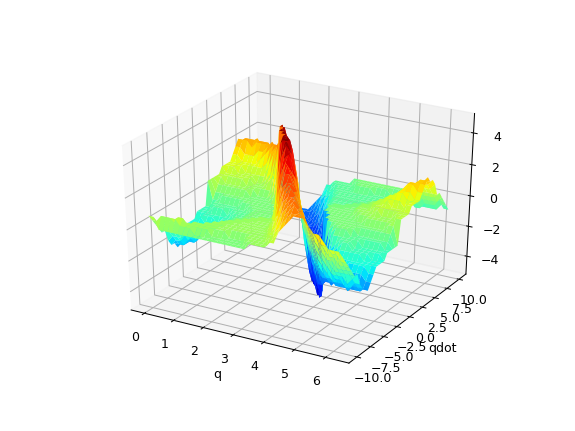

<IPython.core.display.Javascript object>


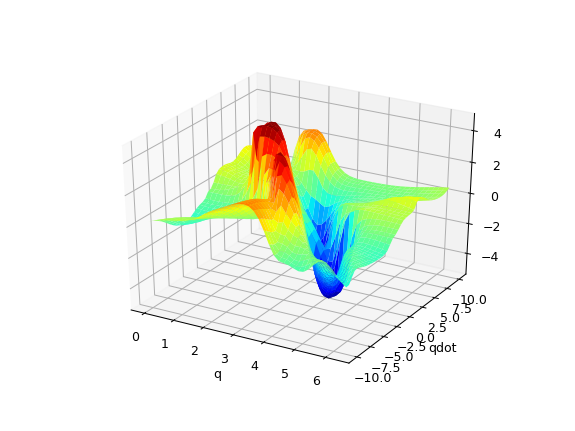

In [211]:
from traj.vi_utils import (
    load_vi_policy,
    vis_vi_policy,
    vis_nn_policy_like_vi_policy
)
vi_policy = load_vi_policy('good', "pendulum")
vis_vi_policy(vi_policy)
vis_nn_policy_like_vi_policy(net, vi_policy)

using_ics=  False
knot_MSE: [13.43466199], traj_MSE: [50.41605436]
[(80000, 2), (80000, 1), (80000, 1)]


<IPython.core.display.Javascript object>


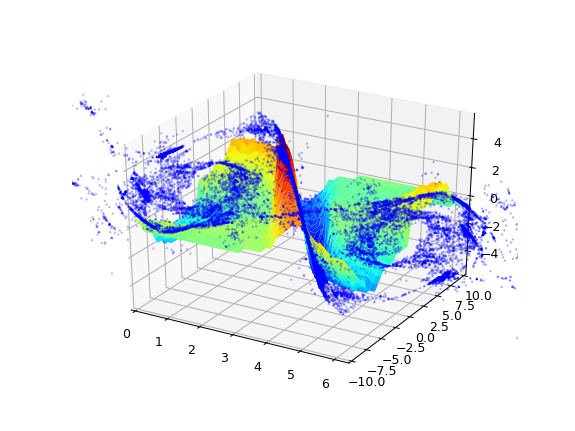

In [201]:
from traj.vi_utils import (graph_vi_policy_vs_traj_knot_scatter)

# ics_or_dircols = ics
ics_or_dircols = dircols
graph_vi_policy_vs_traj_knot_scatter(vi_policy, ics_or_dircols, 
                                     combine_vi_policy_and_scatter=True,
                                     plot_residual=False)